In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
_4dm4_data_fp = 'dataset/4dm4.db'
mwc2021_data_fp = 'dataset/mwc2021.db'
mwc2022_data_fp = 'dataset/mwc2022.db'

_4dm4_data = sqlite3.connect(_4dm4_data_fp)
mwc2021_data = sqlite3.connect(mwc2021_data_fp)
mwc2022_data = sqlite3.connect(mwc2022_data_fp)

In [4]:
mwc2022_query = """SELECT players.player_id, players.player_name, 
beatmaps.beatmap_id, beatmaps.beatmap_typetag, beatmaps.round,
scores.score 
FROM scores JOIN players ON scores.player_id = players.player_id
JOIN beatmaps ON scores.beatmap_id = beatmaps.beatmap_id"""
mwc2021_query = mwc2022_query.replace("players", "player_data").replace("scores", "player_scores")
_4dm4_sql = """SELECT * FROM scores WHERE beatmap_type != \"SV\""""

In [5]:
mwc2021_dataset = pd.read_sql(mwc2021_query, mwc2021_data)
mwc2022_dataset = pd.read_sql(mwc2022_query, mwc2022_data)
_4dm4_dataset = pd.read_sql(_4dm4_sql, _4dm4_data)

In [6]:
mwc2021_dataset['beatmap_typetag'] = mwc2021_dataset['beatmap_typetag'].apply(lambda x: x[:2])
mwc2022_dataset['beatmap_typetag'] = mwc2022_dataset['beatmap_typetag'].apply(lambda x: x[:2])

In [7]:
def logit(x):
    return np.log(x / (1e6 - x))

mwc2021_dataset['score_logit'] = mwc2021_dataset['score'].apply(logit)
mwc2022_dataset['score_logit'] = mwc2022_dataset['score'].apply(logit)

In [8]:
mwc2021_dataset = mwc2021_dataset.rename({'beatmap_typetag': 'beatmap_type', 'beatmap_id': 'beatmap_tag'}, axis=1)
mwc2022_dataset = mwc2022_dataset.rename({'beatmap_typetag': 'beatmap_type', 'beatmap_id': 'beatmap_tag'}, axis=1)

In [9]:
from utils.etimodel import ETIModel, GeneralizedETIModel

mwc2021_model = GeneralizedETIModel(_4dm4_dataset, ['RC', 'HB', 'LN'], l1_alpha=0, l2_alpha=1)
mwc2022_model = GeneralizedETIModel(_4dm4_dataset, ['RC', 'HB', 'LN'], l1_alpha=0, l2_alpha=1)

In [10]:
mwc2021_model.fit_regression(mwc2021_dataset)

In [11]:
mwc2022_model.fit_regression(mwc2022_dataset)

In [12]:
_4dm4_players = _4dm4_dataset['player_name'].unique()
mwc2021_players = mwc2021_dataset['player_name'].unique()
mwc2022_players = mwc2022_dataset['player_name'].unique()

In [13]:
intersect_mwc2021 = np.intersect1d(_4dm4_players, mwc2021_players)
intersect_mwc2022 = np.intersect1d(_4dm4_players, mwc2022_players)

In [14]:
mwc2021_eti = mwc2021_model.transform_eti(mwc2021_dataset)
mwc2022_eti = mwc2022_model.transform_eti(mwc2022_dataset)

In [15]:
mwc2021_eti['4dm4'] = mwc2021_model.predict(mwc2021_dataset)
mwc2022_eti['4dm4'] = mwc2022_model.predict(mwc2022_dataset)

In [16]:
_4dm4_eti = mwc2021_model._4dm_eti()

In [17]:
_4dm4_eti['4dm4'] = _4dm4_eti.mean(axis=1)

In [18]:
_4dm4_eti

,RC,HB,LN,4dm4
drag_,-2.203943,-1.922962,-1.848750,-1.991885
JPBenedictGame,-2.034906,-1.485538,-1.881729,-1.800725
iVALORUS,-2.368395,-1.628269,-2.113531,-2.036732
BL5,-1.515542,-1.421774,-1.379444,-1.438920
-Tebo-,1.049462,0.151761,-1.019061,0.060721
...,...,...,...,...
oliverq,-1.845866,-1.815909,-2.073226,-1.911667
TheFunk,-2.227620,-1.522535,-2.290171,-2.013442
Herarudo,-2.308657,-1.922962,-2.120954,-2.117524
[Antonio],-2.664934,-1.588431,-2.290171,-2.181179


In [24]:
def plot_category(mwc_eti, players, category):
    plt.scatter(mwc_eti.loc[players][category], _4dm4_eti.loc[players]['4dm4'])

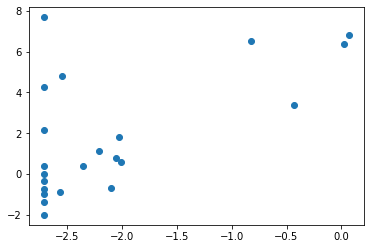

In [25]:
plot_category(mwc2022_eti, intersect_mwc2022, 'RC')

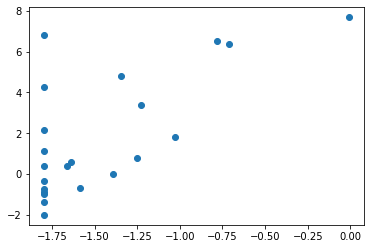

In [26]:
plot_category(mwc2022_eti, intersect_mwc2022, 'HB')

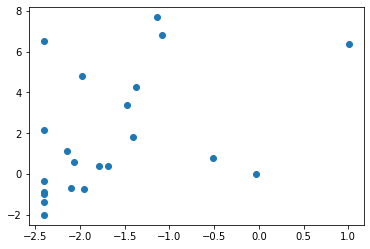

In [27]:
plot_category(mwc2022_eti, intersect_mwc2022, 'LN')

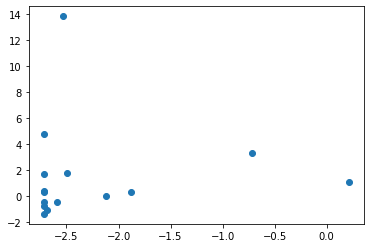

In [28]:
plot_category(mwc2021_eti, intersect_mwc2021, 'RC')

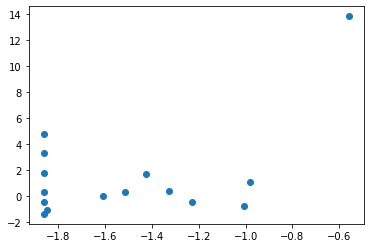

In [29]:
plot_category(mwc2021_eti, intersect_mwc2021, 'HB')

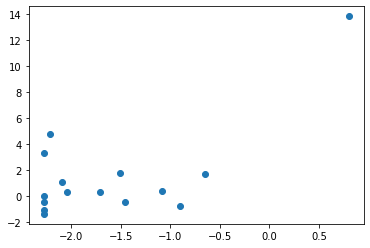

In [30]:
plot_category(mwc2021_eti, intersect_mwc2021, 'LN')

In [32]:
x = mwc2022_eti.loc[intersect_mwc2022][['RC', 'HB', 'LN']].values
y = _4dm4_eti.loc[intersect_mwc2022]['4dm4']

np.corrcoef(x.T, y)

array([[1.        , 0.32688046, 0.45738266, 0.60158948],
       [0.32688046, 1.        , 0.49097963, 0.67672905],
       [0.45738266, 0.49097963, 1.        , 0.43178267],
       [0.60158948, 0.67672905, 0.43178267, 1.        ]])

In [33]:
x = mwc2021_eti.loc[intersect_mwc2021][['RC', 'HB', 'LN']].values
y = _4dm4_eti.loc[intersect_mwc2021]['4dm4']

np.corrcoef(x.T, y)

array([[ 1.        ,  0.16481461, -0.26820072,  0.04550392],
       [ 0.16481461,  1.        ,  0.77810453,  0.49539654],
       [-0.26820072,  0.77810453,  1.        ,  0.67577757],
       [ 0.04550392,  0.49539654,  0.67577757,  1.        ]])

In [40]:
mwc2021_eti.sort_values(by='4dm4', ascending=False).head(20)

,RC,HB,LN,4dm4
cheewee10,6.036247,6.312968,8.545633,18.018527
CrewK,8.203799,5.973097,5.615798,14.866764
SillyFangirl,8.462638,9.250862,3.390216,13.427519
xxxxxx2800,6.578387,3.690497,4.952869,12.957597
Lothus,7.901374,7.898577,3.352533,12.797816
-Aishiteru-,6.954726,3.137075,4.607196,12.430832
Amerom,-0.826117,7.151736,4.611012,12.270062
TriDoanGaming,3.345627,3.470016,4.426408,11.606237
Eliminate,7.034746,4.572104,3.307227,11.408439
jhleetgirl,6.214631,4.405338,3.179980,11.034397


In [37]:
mwc2022_eti.sort_values(by='4dm4', ascending=False).head(20)

,RC,HB,LN,4dm4
SnowScent,13.566323,11.649826,4.282944,23.839939
GripWarrior,11.197839,7.482314,11.631462,22.507524
[Crz]Mitter,12.583247,2.898507,-0.248809,15.996090
bojii,8.406981,4.227826,4.035570,15.401815
Lothus,6.385503,9.258995,-0.423595,15.138012
SillyFangirl,7.670597,4.131022,3.208535,14.460601
gaesol,3.763166,4.779078,7.265180,13.564021
Orost,11.113713,-1.308088,1.789969,13.176577
Poca,2.644928,6.447482,5.046070,12.844192
-Aishiteru-,6.778221,1.598350,2.883705,12.133159
